## Cross Validation

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("data/winequality-red.csv", delimiter=";")

In [3]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
df["quality"].unique()

array([5, 6, 7, 4, 8, 3])

The dataset consists of only 6 types of quality. So we remap them to 0 to 5.

In [5]:
quality_mapping = { 3: 0, 4: 1, 5: 2, 6: 3, 7: 4, 8: 5 }

In [6]:
df.loc[:, "quality"] = df["quality"].map(quality_mapping)

In [7]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,2
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,2
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,2


## Prepare Data

### Shuffle Data

`Sample` function Return a random sample of items from an axis of object. `frac` stands for fraction here. So the code below will return entire dataset, shuffled.

In [8]:
# Shuffle data
df = df.sample(frac=1).reset_index(drop=True)

In [9]:
df.shape

(1599, 12)

`df_train` will have first 1000 rows and `df_test` will have last 599 rows

In [10]:
df_train = df.head(1000)
df_test = df.tail(599)

In [11]:
df_train_data = df_train.drop('quality', axis=1)
df_test_data = df_test.drop('quality', axis=1)

In [12]:
df_train_target = df_train["quality"]
df_test_target = df_test["quality"]

## Preparing Matplotlib

In [13]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [14]:
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)

In [15]:
train_accuracies = []
test_accuracies = []

## Decision Tree Implimentation

In [16]:
from sklearn import tree
from sklearn import metrics

In [17]:
def decision_tree(depth):
    clf = tree.DecisionTreeClassifier(max_depth = depth)
    clf.fit(df_train_data, df_train_target)
    
    # generate predictions on the training set
    train_predictions = clf.predict(df_train_data)

    # generate predictions on the test set
    test_predictions = clf.predict(df_test_data)
    
    # calculate the accuracy of predictions on # training data set
    train_accuracy = metrics.accuracy_score(df_train.quality, train_predictions)
    # calculate the accuracy of predictions on
    # test data set
    test_accuracy = metrics.accuracy_score(df_test.quality, test_predictions)
    
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

In [18]:
for depth in range(1, 25):
    decision_tree(depth)

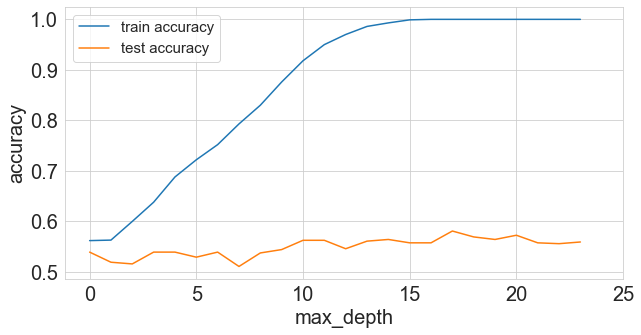

In [19]:
plt.figure(figsize=(10, 5))
sns.set_style("whitegrid")
plt.plot(train_accuracies, label="train accuracy")
plt.plot(test_accuracies, label="test accuracy")
plt.legend(loc="upper left", prop={'size': 15})
plt.xticks(range(0, 26, 5))
plt.xlabel("max_depth", size=20)
plt.ylabel("accuracy", size=20)
plt.show()

The model here is **overfitting**

**Occam’s razor** in simple words states that one should not try to complicate things that can be solved in a much simpler manner. In other words, the simplest solutions are the most generalizable solutions. In general, whenever your model does not obey Occam’s razor, it is probably overfitting.

## On Cross Validation

Splitting data to training and testing data is a kind of cross-validation commonly known as a **hold-out set**. Some other commonly used cross validation techniques are

- k-fold cross-validation
- stratified k-fold cross-validation
- hold-out based validation
- leave-one-out cross-validation
- group k-fold cross-validation

## K-Fold Cross Validation
We can divide the data into k different sets which are exclusive of each other. This is known as k-fold cross-validation.

1. Shuffle the dataset randomly.
2. Split the dataset into k groups
3. For each unique group:
    1. Take the group as a hold out or test data set
    2. Take the remaining groups as a training data set
    3. Fit a model on the training set and evaluate it on the test set
    4. Retain the evaluation score and discard the model
4. Summarize the skill of the model using the sample of model evaluation scores

### Configuration of k
The k value must be chosen carefully for your data sample.

>The choice of k is usually 5 or 10, but there is no formal rule. As k gets larger, the difference in size between the training set and the resampling subsets gets smaller. As this difference decreases, the bias of the technique becomes smaller
>
> — Page 70, Applied Predictive Modeling, 2013.

In [20]:
import pandas as pd
from sklearn import model_selection

In [21]:
df = pd.read_csv("data/winequality-red.csv", delimiter=";")

# we create a new column called kfold and fill it with -1
df["kfold"] = -1

# the next step is to randomize the rows of the data
df = df.sample(frac=1).reset_index(drop=True)

In [22]:
# initiate the kfold class from model_selection module
kf = model_selection.KFold(n_splits=5)

In [23]:
for fold, (trn_, val_) in enumerate(kf.split(X=df)):
    df.loc[val_, 'kfold'] = fold

In [24]:
df["kfold"].unique()

array([0, 1, 2, 3, 4])

Now, the df can be grouped and separated. The idea is to train on certain of these folds and then test on the remaining.

## Stratified K-Fold Cross Validation
The splitting of data into folds may be governed by criteria such as ensuring that each fold has the same proportion of observations with a given categorical value, such as the class outcome value. This is called stratified cross-validation.

In [1]:
import pandas as pd
from sklearn import model_selection

In [7]:
df = pd.read_csv("data/winequality-red.csv", delimiter=";")

# we create a new column called kfold and fill it with -1
df["kfold"] = -1

# the next step is to randomize the rows of the data
df = df.sample(frac=1).reset_index(drop=True)

In [9]:
# fetch targets
y = df.quality.values

In [10]:
# initiate the kfold class from model_selection module
kf = model_selection.StratifiedKFold(n_splits=5)

In [12]:
for f, (t_, v_) in enumerate(kf.split(X=df, y=y)):
    df.loc[v_, 'kfold'] = f

In [13]:
df["kfold"].unique()

array([0, 1, 2, 3, 4])

## Using Stratified K-Fold Cross Validation In Regression

To use stratified **k-fold for a regression problem**, we have first to divide the target into bins, and then we can use stratified k-fold in the same way as for classification problems. There are several choices for selecting the appropriate number of **bins**. If you have a lot of samples( > 10k, > 100k), then you don’t need to care about the number of bins. Just divide the data into 10 or 20 bins. If you do not have a lot of samples, you can use a simple rule like **Sturge’s Rule** to calculate the appropriate number of bins.

Sturge’s rule: Number of $ Bins = 1 + {log}_{2}(N) $

## Variations on Cross-Validation
There are a number of variations on the k-fold cross validation procedure. Three commonly used variations are as follows:

- **Train/Test Split**: Taken to one extreme, k may be set to 2 (not 1) such that a single train/test split is created to evaluate the model.
- **LOOCV**: Taken to another extreme, k may be set to the total number of observations in the dataset such that each observation is given a chance to be the held out of the dataset. This is called leave-one-out cross-validation, or LOOCV for short.
- **Repeated**: This is where the k-fold cross-validation procedure is repeated n times, where importantly, the data sample is shuffled prior to each repetition, which results in a different split of the sample.
- **Nested**: This is where k-fold cross-validation is performed within each fold of cross-validation, often to perform hyperparameter tuning during model evaluation. This is called nested cross-validation or double cross-validation.